In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# 1. 학습

## 라이브러리 임포트

In [2]:
import os
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import random

import math
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torch.autograd import Variable

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import cv2
from IPython.display import display
from PIL import Image

from dataclasses import dataclass, field
from typing import Tuple, List

import warnings
warnings.filterwarnings('ignore')

from enum import Enum

class ModelType(Enum):
  BEST = "best"
  LAST = "last"

class DataType(Enum):
  TRAIN = "train"
  VAL = "val"
  TEST = "test"

base_dir = "/content/drive/MyDrive/DMS"


## 1-2. LSTM Input 형식으로 변환

### Config 설정

In [3]:
from dataclasses import dataclass

@dataclass
class Config:
    case_name: str = "bi-lstm_attention_ensemble_24f/optuna/folds_adamw_prune" # 바꿔야하는 부분

    # 모델 구조
    lstm_num_layers: int = 3
    lstm_hidden_size: int = 512
    fc_hidden_size: int = 256
    dropout_rate: float = 0.2 # input-to-hidden (between layers)
    bidirectional: bool = True

    # 학습 설정
    batch_size: int = 32
    epochs: int = 100
    learning_rate: float = 3e-4
    optimizer: str = "adam" # or "sgd", "adamw"

    # 입력 데이터(수정한 부분)
    sequence_length: int = 24
    sliding_window_step: int = 24 # sliding window 사용 x -> seuqnce_length와 같은 값으로 설정
    features: list = field(default_factory=lambda: ["mar", "ear", "yaw", "pitch", "phone_detected"])
    labels: list = field(default_factory=lambda: ["normal", "phonecall", "text", "yawn"])

    apply_yaw_inversion: bool = False
    apply_noise_jittering: bool = False

    # 학습 제어 - 조기 종료 / 러닝레이트 스케줄러
    use_early_stopping: bool = False  # 조기 종료 사용 여부
    use_lr_scheduler: bool = False    # 학습률 스케줄러 사용 여부
    early_stopping_patience: int = 20 # early stopping 기준 epoch
    reduce_lr_factor: float = 0.5 # learning rate 감소 비율
    reduce_lr_patience: int = 7 # learning rate 감소 기준 epoch

    # 랜덤시드 설정
    random_seed: int = 24

    def __post_init__(self):
      self.results_save_path = f"{base_dir}/runs/{self.case_name}"
      self.model_save_path = f"{self.results_save_path}/weights"

      os.makedirs(self.results_save_path, exist_ok=True)
      os.makedirs(self.model_save_path, exist_ok=True)

      if self.sequence_length == 12:
        df_path = f'{base_dir}/data/splits/12frame_windows'
        self.group_col = 'groups_12'
      elif self.sequence_length == 24:
        df_path = f'{base_dir}/data/splits/24frame_windows'
        self.group_col = 'groups_24'

      self.train = pd.read_csv(os.path.join(df_path, "final_train.csv"))
      self.validation = pd.read_csv(os.path.join(df_path, "final_val.csv"))
      self.test = pd.read_csv(os.path.join(df_path, "final_test.csv"))

      # label_mapping
      self.label_encoding = {}
      self.label_decoding = {}
      for i, label in enumerate(self.labels):
          self.label_encoding[label] = i # 문자열 라벨 : 숫자 인덱스
          self.label_decoding[i] = label # 숫자 인덱스 : 문자열 라벨

      # 디바이스 설정
      self.use_cuda = torch.cuda.is_available()
      self.device = torch.device("cuda" if self.use_cuda else "cpu")

cfg = Config()
# print(cfg.case_name) # 사용 예시

In [4]:
def set_random_seed(seed):
    torch.manual_seed(seed)  # PyTorch CPU 연산에 대한 시드 설정
    torch.cuda.manual_seed(seed)  # CUDA 연산에 대한 시드 설정 (GPU 사용 시)
    torch.cuda.manual_seed_all(seed)  # 여러 GPU를 사용하는 경우 모든 GPU에 동일한 시드 설정
    np.random.seed(seed)  # NumPy 연산에 대한 시드 설정
    random.seed(seed)  # Python 기본 random 모듈의 시드 설정
    torch.backends.cudnn.deterministic = True  # CuDNN 연산의 결정론적 동작 보장
    torch.backends.cudnn.benchmark = False  # 성능 최적화 비활성화 (재현성 보장)

set_random_seed(cfg.random_seed)

### 데이터 로드

### train, val, test 데이터셋 로드

In [5]:
train_df = cfg.train.copy()
val_df = cfg.validation.copy()
test_df = cfg.test.copy()

In [6]:
# train normal undersampling
train_df = train_df[((train_df['label'] == 'normal') &
                    (train_df[cfg.group_col].isin([1, 2]))) | # sequence_length에 따라 group_col이 설정됨 -> 파일 로드 -> group_col로 정의된 groups_12 열 가져오기
                    (train_df['label'] != 'normal')]

### generate_sequence_dataset

In [7]:
def generate_sequence_dataset(
    df: pd.DataFrame
) -> Tuple[np.ndarray, np.ndarray, List[Tuple]]: # 가독성을 위해 변환 타입 명시. 작동x
    sequences, labels, metadata = [], [], []

    for (label, clip_id), clip_df in df.groupby(['label', 'clip_id']):
        clip_df = clip_df.sort_values('frame_no')
        frame_values = clip_df[cfg.features].values #(프레임 수, 변수 수)

        if len(frame_values) < cfg.sequence_length:
            continue

        for i in range(0, len(frame_values) - cfg.sequence_length + 1, cfg.sliding_window_step): # 전체 120, 슬라이딩 윈도우 12라면 (0, 109, 12)로 잘 들어간다
            seq = frame_values[i:i + cfg.sequence_length]
            if seq.shape[0] == cfg.sequence_length:
                sequences.append(seq)
                labels.append(cfg.label_encoding[label])
                # 학습 후 오분류 데이터 확인을 위한 시작 프레임 번호 저장
                metadata.append((label, clip_id, clip_df.iloc[i]['frame_no']))

    return TensorDataset(torch.tensor(sequences, dtype=torch.float32), torch.tensor(labels, dtype=torch.long)), metadata

### DataLoader

In [8]:
train_params = {
    "batch_size": cfg.batch_size,
    "shuffle": True,
    "num_workers": 4,
    "pin_memory": cfg.use_cuda,
    "persistent_workers": cfg.use_cuda,
    "prefetch_factor": 2 if cfg.use_cuda else None,
}

test_params = {
    "batch_size": cfg.batch_size,
    "shuffle": False,
    "num_workers": 0,
    "pin_memory": cfg.use_cuda
}

In [9]:
# DataLoader 생성 (배치 단위로 데이터를 나누기 위해 사용)
train_dataset, train_metadata = generate_sequence_dataset(train_df)
val_dataset, val_metadata = generate_sequence_dataset(val_df)
test_dataset, test_metadata = generate_sequence_dataset(test_df)

train_loader = DataLoader(train_dataset, **train_params)
val_loader = DataLoader(val_dataset, **test_params)
test_loader = DataLoader(test_dataset, **test_params)

# 배치 단위 확인
for x_batch, y_batch in train_loader:
    print("Batch Shape:", x_batch.shape, y_batch.shape)  # (batch_size, timestep, feature), (batch_size,)
    break  # 한 배치만 확인

for x_batch, y_batch in val_loader:
    print("Batch Shape:", x_batch.shape, y_batch.shape)  # (batch_size, timestep, feature), (batch_size,)
    break  # 한 배치만 확인

for x_batch, y_batch in test_loader:
    print("Batch Shape:", x_batch.shape, y_batch.shape)  # (batch_size, timestep, feature), (batch_size,)
    break  # 한 배치만 확인

Batch Shape: torch.Size([32, 24, 5]) torch.Size([32])
Batch Shape: torch.Size([32, 24, 5]) torch.Size([32])
Batch Shape: torch.Size([32, 24, 5]) torch.Size([32])


## 1-3. 모델 로드

### 모델 준비 함수

In [10]:
# 모델 준비
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim, hidden_dim)
        self.context = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, lstm_output):
        # lstm_output: [B, T, H]
        score = torch.tanh(self.attn(lstm_output))         # [B, T, H]
        attn_weights = torch.softmax(self.context(score), dim=1)  # [B, T, 1]
        attended_output = torch.sum(attn_weights * lstm_output, dim=1)  # [B, H]
        return attended_output, attn_weights  # context vector, weights

In [11]:
# LSTM 모델 정의
class DecoderRNN(nn.Module):
    def __init__(self, lstm_hidden_size, fc_hidden_size, dropout_rate):
        super(DecoderRNN, self).__init__()

        self.RNN_input_size = len(cfg.features)
        self.h_RNN_layers = cfg.lstm_num_layers
        self.h_RNN = lstm_hidden_size
        self.h_FC_dim = fc_hidden_size
        self.drop_p = dropout_rate
        self.num_classes = len(cfg.labels)
        self.bidirectional = cfg.bidirectional

        self.LSTM = nn.LSTM(
            input_size=self.RNN_input_size,
            hidden_size=self.h_RNN,
            num_layers=self.h_RNN_layers,
            batch_first=True,
            bidirectional=self.bidirectional
        )

        lstm_output_dim = self.h_RNN * (2 if self.bidirectional else 1)

        self.attention = Attention(lstm_output_dim) # Attention 추가
        self.fc1 = nn.Linear(lstm_output_dim, self.h_FC_dim)
        self.bn1 = nn.BatchNorm1d(self.h_FC_dim)  # Batch Normalization 추가
        self.fc2 = nn.Linear(self.h_FC_dim, self.num_classes)
        self.dropout = nn.Dropout(p=self.drop_p)

    def forward(self, x_RNN):
        self.LSTM.flatten_parameters()
        out, _ = self.LSTM(x_RNN)  # (batch, seq_len, hidden*2)

        attn_out, attn_weights = self.attention(out)  # attn_out: [B, H]

        # FC layers
        x = self.fc1(attn_out)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x, attn_weights  # CrossEntropyLoss 사용 (Softmax 없음), attn_weights 함께 반환

### 모델 로드 함수

In [12]:
# 모델 로드 함수
def load_model(model, device, model_type=ModelType.BEST):
    """저장된 모델을 불러오는 함수"""
    model_path = os.path.join(cfg.model_save_path, f"{model_type.value}_model.pth")
    checkpoint = torch.load(model_path, map_location=device)
    #torch.save로 저장된 모델은 모델 가중치만 저장되어 있어 미리 모델 구조를 정의해줘야 한다
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()
    print(f"✅ Model Loaded from {model_path}")
    return model

### 예측값 출력 함수

In [13]:
def get_preds_and_labels_ensemble(models: List[torch.nn.Module], device, data_loader, print_sample=False, max_print=10):
    """
    앙상블 모델을 이용한 예측 결과 및 입력/출력 정보 반환
    """
    for model in models:
        model.eval()

    all_inputs = []
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # 각 모델에 대해 softmax 확률 계산
            ensemble_probs = []
            for model in models:
                logits = model(x_batch)
                if isinstance(logits, tuple):
                    logits = logits[0]
                probs = F.softmax(logits, dim=1)
                ensemble_probs.append(probs)

            # 확률 평균
            avg_probs = torch.stack(ensemble_probs).mean(dim=0)
            preds = torch.argmax(avg_probs, dim=1)

            all_inputs.extend(x_batch.cpu())
            all_labels.extend(y_batch.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(avg_probs.cpu().numpy())

    # 옵션: 일부 샘플 출력
    if print_sample:
        print("=== Sample Predictions ===")
        for i in range(min(max_print, len(all_labels))):
            print(f"[{i}] True: {all_labels[i]} | Pred: {all_preds[i]} | Prob: {all_probs[i]}")

    return (
        torch.stack(all_inputs),          # shape: [N, T, F]
        np.array(all_labels),             # shape: [N]
        np.array(all_preds),              # shape: [N]
        np.array(all_probs),              # shape: [N, num_classes]
    )


### 실행

In [14]:
import glob

def load_all_best_models(lstm_hidden_size, fc_hidden_size, dropout_rate, device) -> List[torch.nn.Module]:
    """폴더 내 모든 best_model_*.pth 파일을 불러와 모델 리스트 반환"""
    model_list = []
    pattern = os.path.join(cfg.model_save_path, "best_model_*.pth")
    model_paths = sorted(glob.glob(pattern))

    for path in model_paths:
        model = DecoderRNN(lstm_hidden_size, fc_hidden_size, dropout_rate).to(device)
        checkpoint = torch.load(path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        model.eval()
        model_list.append(model)
        print(f"✅ Loaded: {os.path.basename(path)}")

    return model_list

In [15]:
models = load_all_best_models(cfg.lstm_hidden_size, cfg.fc_hidden_size, cfg.dropout_rate, cfg.device) # best model load

✅ Loaded: best_model_0.pth
✅ Loaded: best_model_1.pth
✅ Loaded: best_model_2.pth
✅ Loaded: best_model_3.pth
✅ Loaded: best_model_4.pth


In [16]:
all_test_inputs, all_test_labels, all_test_preds, all_test_probs = get_preds_and_labels_ensemble(models, cfg.device, test_loader)

# 2. 해석 기법 도입

'''
목표 : 특성들을 사용해 어떻게 예측하는지 확인
1. 어텐션, shap, ig는 원래 개별 샘플에 적용하는 것인데 전체적인 경향성을 보기 위해 전체 데이터에 적용한 후 평균값을 이용한다. 더불어 std값도 병기
2. 어텐션에서 타임스탭별 평균값을 구하고 나머지는 특성별 평균값만 다룬다
3. 라벨별로 특성이 어떻게 적용되어서 예측되는지가 핵심이기에 라벨별로 계산 후 시각화한다
4. 테스트셋에 대하여 실제 라벨을 기준으로 한다
5. ig, shap는 계산이 느리므로 배치를 사용한다
'''

## 2-0. 필요한 함수들

In [17]:
from collections import defaultdict # 존재하지 않는 키에 접근할 때 자동으로 기본값을 생성

def get_class_indices(dataset, label_decoding):
    '''각 라벨에 해당하는 인덱스를 모아주는 함수'''
    # dataset은 파이토치 데이터셋 클래스. 시퀀스 등 다차원 배열의 데이터셋 다루기 위함
    class_indices = defaultdict(list)

    for idx in range(len(dataset)):
    # idx는 각 샘플의 인덱스 번호로 처음부터 끝까지 순환한다
        _, label_idx = dataset[idx]
    # dataset[idx]는 (입력값, 클래스 인덱스) 튜플을 반환
        label_name = label_decoding[label_idx.item()]
        # tensor(2)과 같은 파이토치 텐서를 item()으로 int로 변환
        # label_decoding으로 클래스 인덱스->클래스 문자 라벨 매핑
        class_indices[label_name].append(idx)
        # class_indices는 딕셔너리 형태. 클래스 문자를 처음 받으면 defaultdict를 사용해 빈 리스트를 만들고 거기에 idx추가
        # 모든 샘플 반복

    return class_indices

## 2-1. Attention

In [18]:
def visualize_attention_feature_avg_by_class_ensemble(models: List[torch.nn.Module], dataset, class_indices: dict, feature_names=None):
    for model in models:
        model.eval()

    num_classes = len(class_indices)
    feature_names = feature_names or [f'F{i}' for i in range(len(cfg.features))]

    fig, axes = plt.subplots(3, num_classes, figsize=(4 * num_classes, 10))
    if num_classes == 1:
        axes = np.expand_dims(axes, axis=1)

    for i, (label_name, indices) in enumerate(class_indices.items()):
        attn_list_all_models = []
        feature_list_all_models = []

        for sample_idx in indices:
            x_seq, label = dataset[sample_idx]
            x_seq = x_seq.unsqueeze(0).to(cfg.device)  # (1, T, F)

            attn_per_model = []
            feature_per_model = []

            for model in models:
                with torch.no_grad():
                    output, attn_weights = model(x_seq)  # (1, T)
                attn_weights = attn_weights.squeeze().cpu().numpy()  # (T,)
                x_np = x_seq.squeeze().cpu().numpy()                 # (T, F)

                attn_per_model.append(attn_weights)
                feature_per_model.append(x_np)

            # 모델 평균
            attn_avg = np.mean(np.stack(attn_per_model), axis=0)       # (T,)
            feature_avg = np.mean(np.stack(feature_per_model), axis=0) # (T, F)

            attn_list_all_models.append(attn_avg)
            feature_list_all_models.append(feature_avg)

        # 클래스 평균
        attn_array = np.stack(attn_list_all_models)           # (N, T)
        feature_array = np.stack(feature_list_all_models)     # (N, T, F)

        attn_mean = attn_array.mean(axis=0)
        attn_std = attn_array.std(axis=0)
        feature_mean = feature_array.mean(axis=0)             # (T, F)

        time_steps = list(range(len(attn_mean)))

        # --- 시각화 ---
        ax1 = axes[0][i]
        sns.heatmap(feature_mean.T, cmap='viridis', cbar=True, xticklabels=time_steps,
                    yticklabels=feature_names, ax=ax1)
        ax1.set_title(f"[{label_name}] Mean Input Features")
        ax1.set_xlabel("Time Step")
        ax1.set_ylabel("Feature")

        ax2 = axes[1][i]
        sns.barplot(x=time_steps, y=attn_mean, ax=ax2)
        ax2.set_title(f"[{label_name}] Mean Attention Weights")
        ax2.set_xlabel("Time Step")
        ax2.set_ylabel("Weight")

        ax3 = axes[2][i]
        sns.barplot(x=time_steps, y=attn_std, ax=ax3)
        ax3.set_title(f"[{label_name}] Std Attention Weights")
        ax3.set_xlabel("Time Step")
        ax3.set_ylabel("Weight")

    plt.tight_layout()
    save_path = os.path.join(cfg.results_save_path, "attention_feature_mean_comparison_ensemble.png")
    plt.savefig(save_path, dpi=300)
    plt.show()
    plt.close()
    print(f"✅ Ensemble Attention and feature mean comparison saved at: {save_path}")


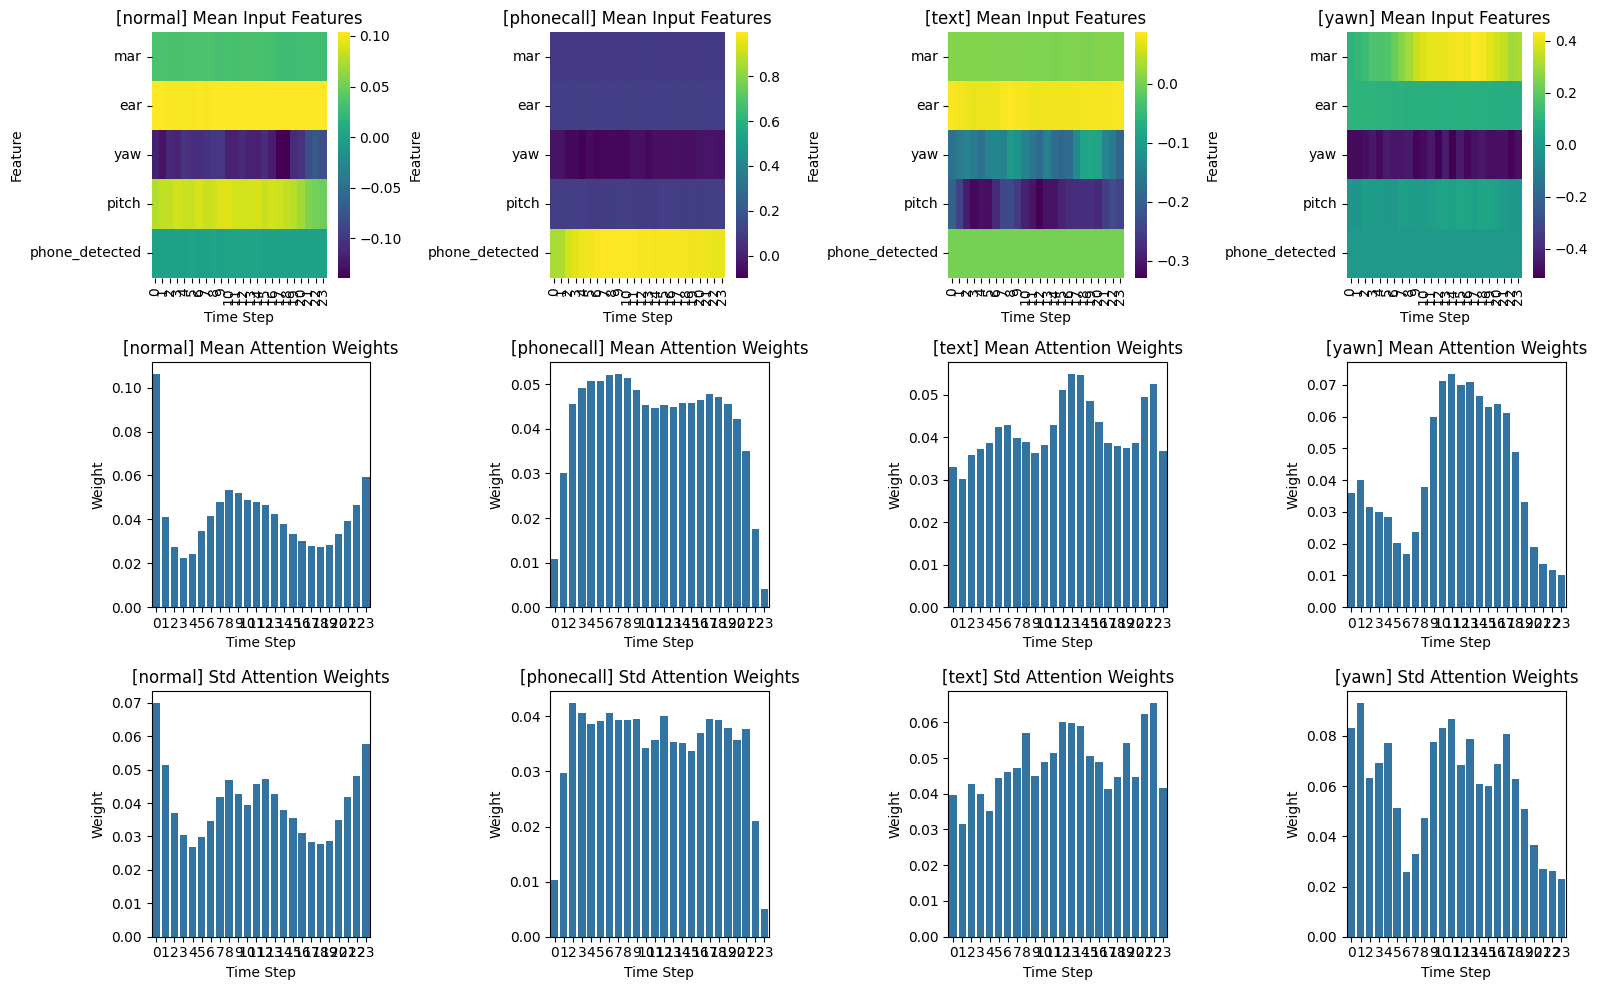

✅ Ensemble Attention and feature mean comparison saved at: /content/drive/MyDrive/DMS/runs/bi-lstm_attention_ensemble_24f/optuna/folds_adamw_prune/attention_feature_mean_comparison_ensemble.png


In [19]:
class_indices = get_class_indices(test_dataset, cfg.label_decoding)

visualize_attention_feature_avg_by_class_ensemble(
    models=models,
    dataset=test_dataset,
    class_indices=class_indices,
    feature_names=['mar', 'ear', 'yaw', 'pitch', 'phone_detected']
)


'''
1. 전체 평균에서는 attention 가중치 차이가 작아짐
각 샘플의 패턴이나 특징 위치가 달라서, 중요하게 여기는 타임스텝이 달라진다.
여러 샘플을 평균내면, 서로 다른 주목 위치가 서로를 상쇄시키거나 희석시켜 전체 평균이 완만해지는 경향이 있습니다.
2. 평균값이 크면 표준편차도 크고, 작으면 작다
어떤 샘플의 attention 평균이 크다는 건, 여러 샘플이 해당 time step을 자주 중요하게 여겼다는 것이지만
하지만 중요하게 여기는 정도가 샘플마다 다르면, 당연히 편차도 커진다
어텐션은 시각적 직관을 제공하는 도구이지, 원인적 기여도를 수치화해주는 도구는 아니다
'''